# Lab3 ResNet18 with weighted loss

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import copy
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4.0
True


## DataSet & DataLoader
data augmentation:  
1. RandomHorizontalFlip
2. RandomVerticalFilp
3. Normalize each channel(R,G,B)

In [2]:
class RetinopathyDataSet(Dataset):
    def __init__(self, img_path, mode):
        """
        Args:
            img_path: Root path of the dataset.
            mode: training/testing
            
            self.img_names (string list): String list that store all image names.
            self.labels (int or float list): Numerical list that store all ground truth label values.
        """
        self.img_path = img_path
        self.mode = mode
        
        self.img_names=np.squeeze(pd.read_csv('train_img.csv' if mode=='train' else 'test_img.csv').values)
        self.labels=np.squeeze(pd.read_csv('train_label.csv' if mode=='train' else 'test_label.csv').values)
        assert len(self.img_names)==len(self.labels),'length not the same'
        self.data_len=len(self.img_names)
        
        self.transformations=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor()])
        print(f'>> Found {self.data_len} images...')
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        single_img_name=os.path.join(self.img_path,self.img_names[index]+'.jpeg')
        single_img=Image.open(single_img_name)  # read an PIL image
        img=self.transformations(single_img)
        label=self.labels[index]
        
        return img, label

## Model
1. ResNet18 (with/wo pretrained weights)
2. ResNet50 (with/wo pretrained weights)

reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks  

In [3]:
class ResNet18(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet18,self).__init__()
        self.model=models.resnet18(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out
    
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet50,self).__init__()
        self.model=models.resnet50(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out

## Train & Evaluate

In [4]:
def train(model,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,name):
    """
    Args:
        model: resnet model
        loader_train: training dataloader
        loader_test: testing dataloader
        Loss: loss function
        optimizer: optimizer
        epochs: number of training epoch
        device: gpu/cpu
        num_class: #target class
        name: model name when saving model
    Returns:
        dataframe: with column 'epoch','acc_train','acc_test'
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts=None
    best_evaluated_acc=0
    
    model.to(device)
    acc_train=list()
    acc_test=list()
    for epoch in range(1,epochs+1):
        """
        train
        """
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for images,targets in loader_train:
                images,targets=images.to(device),targets.to(device,dtype=torch.long)
                predict=model(images)
                loss=Loss(predict,targets)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(targets).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            acc=100.*correct/len(loader_train.dataset)
            acc_train.append(acc)
            print(f'epoch{epoch:>2d} loss:{total_loss:.4f} acc:{acc:.2f}%')
        """
        evaluate
        """
        _,acc=evaluate(model,loader_test,device,num_class)
        acc_test.append(acc)
        # update best_model_wts
        if acc>best_evaluated_acc:
            best_evaluated_acc=acc
            best_model_wts=copy.deepcopy(model.state_dict())
    
    df['acc_train']=acc_train
    df['acc_test']=acc_test
    
    # save model
    torch.save(best_model_wts,os.path.join('models',name+'.pt'))
    model.load_state_dict(best_model_wts)
    
    return df

In [5]:
def evaluate(model,loader_test,device,num_class):
    """
    Args:
        model: resnet model
        loader_test: testing dataloader
        device: gpu/cpu
        num_class: #target class
    Returns:
        confusion_matrix: (num_class,num_class) ndarray
        acc: accuracy rate
    """
    confusion_matrix=np.zeros((num_class,num_class))
    
    with torch.set_grad_enabled(False):
        model.eval()
        correct=0
        for images,targets in loader_test:  
            images,targets=images.to(device),targets.to(device,dtype=torch.long)
            predict=model(images)
            predict_class=predict.max(dim=1)[1]
            correct+=predict_class.eq(targets).sum().item()
            for i in range(len(targets)):
                confusion_matrix[int(targets[i])][int(predict_class[i])]+=1
        acc=100.*correct/len(loader_test.dataset)
        
    # normalize confusion_matrix
    confusion_matrix=confusion_matrix/confusion_matrix.sum(axis=1).reshape(num_class,1)
    
    return confusion_matrix,acc

## Plot

In [6]:
def plot(dataframe1,dataframe2,title):
    """
    Arguments:
        dataframe1: dataframe with 'epoch','acc_train','acc_test' columns of without pretrained weights model 
        dataframe2: dataframe with 'epoch','acc_train','acc_test' columns of with pretrained weights model 
        title: figure's title
    Returns:
        figure: an figure
    """
    fig=plt.figure(figsize=(10,6))
    for name in dataframe1.columns[1:]:
        plt.plot(range(1,1+len(dataframe1)),name,data=dataframe1,label=name[4:]+'(w/o pretraining)')
    for name in dataframe2.columns[1:]:
        plt.plot(range(1,1+len(dataframe2)),name,data=dataframe2,label=name[4:]+'(with pretraining)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend()
    return fig

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    ax.xaxis.set_label_position('top')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(i, j, '{:.2f}'.format(confusion_matrix[j, i]), va='center', ha='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    return fig

## Hyperparameters
__num_class__: 5  
__batch_size:__  
1. Resnet18: 64
2. Resnet50: 16

__learning rate:__ 1e-3  
__Epochs:__  
1. model wo pretrained weights: 15
2. model with pretrained weights: 5(feature extraction) + 10(finetuning)

__Optimizer:__ SGD,momentum=0.9,weight_decay=5e-4  
__loss function:__ cross entropy with weighted loss  

In [7]:
num_class=5
batch_size=64
lr=1e-3
epochs=40
epochs_feature_extraction=5
epochs_fine_tuning=35
momentum=0.9
weight_decay=5e-4
Loss=nn.CrossEntropyLoss(weight=torch.Tensor([1.0,10.565217391304348,4.906175771971497,29.591690544412607,35.55077452667814]).to(device))

# Run ResNet18

In [8]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.0260 acc:22.69%
epoch 2 loss:0.0257 acc:25.16%
epoch 3 loss:0.0255 acc:26.50%
epoch 4 loss:0.0250 acc:29.07%
epoch 5 loss:0.0248 acc:29.57%
epoch 6 loss:0.0248 acc:28.46%
epoch 7 loss:0.0246 acc:29.26%
epoch 8 loss:0.0246 acc:30.79%
epoch 9 loss:0.0245 acc:30.85%
epoch10 loss:0.0244 acc:29.85%
epoch11 loss:0.0243 acc:30.86%
epoch12 loss:0.0241 acc:31.40%
epoch13 loss:0.0241 acc:31.63%
epoch14 loss:0.0240 acc:30.64%
epoch15 loss:0.0238 acc:31.16%
epoch16 loss:0.0238 acc:31.15%
epoch17 loss:0.0237 acc:31.98%
epoch18 loss:0.0236 acc:33.05%
epoch19 loss:0.0235 acc:30.51%
epoch20 loss:0.0234 acc:32.92%
epoch21 loss:0.0232 acc:33.01%
epoch22 loss:0.0229 acc:33.75%
epoch23 loss:0.0226 acc:34.23%
epoch24 loss:0.0223 acc:35.62%
epoch25 loss:0.0222 acc:37.72%
epoch26 loss:0.0218 acc:37.90%
epoch27 loss:0.0212 acc:38.57%
epoch28 loss:0.0211 acc:38.81%
epoch29 loss:0.0207 acc:40.15%
epoch30 loss:0.0204 acc:40.82%
epoch31 loss:0.0202 acc:40.27%
epoch32 loss:0.0198 acc:40.58%
epoch33 

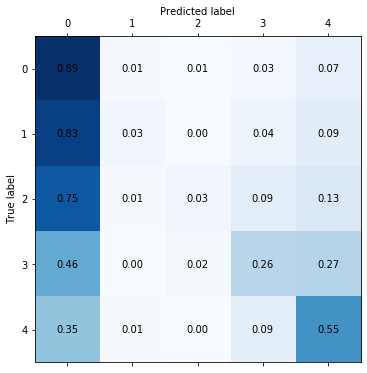

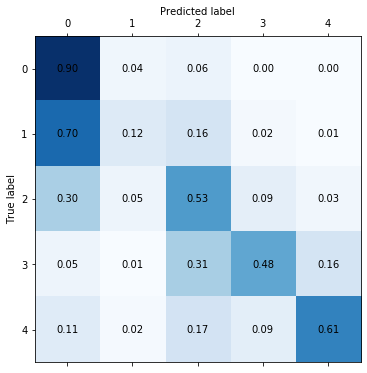

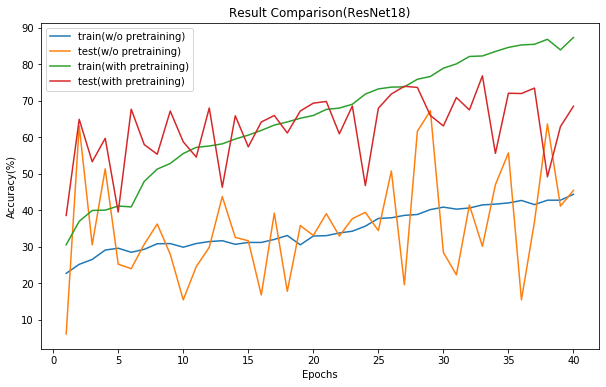

In [9]:
"""
resnet18 without pretrained weights
"""
model_wo=ResNet18(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet18_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (wo pretrained weights).png')

"""
resnet18 with pretrained weights
    feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet18(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet18_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet18_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_wo_pretrained,df_with_pretrained,'Result Comparison(ResNet18)')
figure.savefig('Result Comparison(ResNet18).png')

In [10]:
print(df_wo_pretrained)
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  22.694758   6.092527
1       2  25.161038  63.074733
2       3  26.502723  30.491103
3       4  29.068650  51.302491
4       5  29.570447  25.209964
5       6  28.463646  23.971530
6       7  29.264387  30.647687
7       8  30.794690  36.199288
8       9  30.848073  27.928826
9      10  29.851596  15.444840
10     11  30.858749  24.526690
11     12  31.396135  29.822064
12     13  31.627460  43.715302
13     14  30.641660  32.555160
14     15  31.157692  31.615658
15     16  31.150575  16.782918
16     17  31.979786  39.174377
17     18  33.050998  17.779359
18     19  30.506424  35.772242
19     20  32.915762  33.067616
20     21  33.011851  39.032028
21     22  33.752091  32.911032
22     23  34.232535  37.665480
23     24  35.620485  39.402135
24     25  37.723762  34.405694
25     26  37.901705  50.718861
26     27  38.567209  19.572954
27     28  38.812769  61.594306
28     29  40.147336  67.217082
29     30  40.823517  28.412811
30     3

## Run ResNet50

In [11]:
batch_size=16

In [12]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.1116 acc:36.73%
epoch 2 loss:0.1010 acc:45.03%
epoch 3 loss:0.1011 acc:47.56%
epoch 4 loss:0.0994 acc:48.39%
epoch 5 loss:0.0999 acc:46.63%
epoch 6 loss:0.0990 acc:52.80%
epoch 7 loss:0.0987 acc:50.03%
epoch 8 loss:0.0982 acc:48.98%
epoch 9 loss:0.0982 acc:50.16%
epoch10 loss:0.0978 acc:49.45%
epoch11 loss:0.0977 acc:48.59%
epoch12 loss:0.0978 acc:49.37%
epoch13 loss:0.0975 acc:47.89%
epoch14 loss:0.0974 acc:48.77%
epoch15 loss:0.0973 acc:48.81%
epoch16 loss:0.0968 acc:48.25%
epoch17 loss:0.0969 acc:48.48%
epoch18 loss:0.0967 acc:48.94%
epoch19 loss:0.0965 acc:50.71%
epoch20 loss:0.0965 acc:49.52%
epoch21 loss:0.0962 acc:48.49%
epoch22 loss:0.0962 acc:49.32%
epoch23 loss:0.0961 acc:48.54%
epoch24 loss:0.0959 acc:51.51%
epoch25 loss:0.0957 acc:49.29%
epoch26 loss:0.0962 acc:45.85%
epoch27 loss:0.0962 acc:48.25%
epoch28 loss:0.0957 acc:47.92%
epoch29 loss:0.0956 acc:48.40%
epoch30 loss:0.0955 acc:50.52%
epoch31 loss:0.0952 acc:51.22%
epoch32 loss:0.0957 acc:50.34%
epoch33 

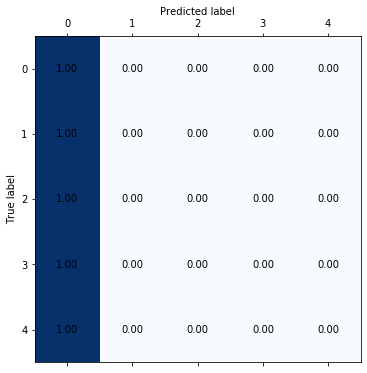

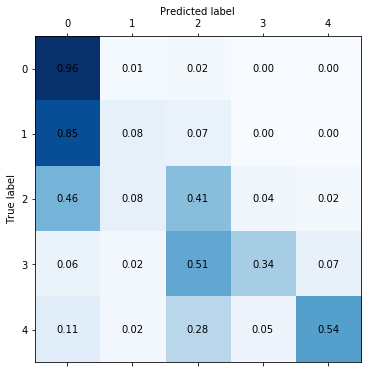

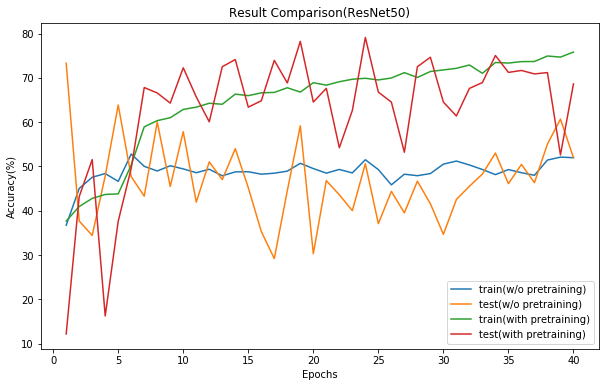

In [13]:
"""
resnet50 without pretrained weights
"""
model_wo=ResNet50(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet50_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (wo pretrained weights).png')

"""
resnet50 with pretrained weights
    first feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet50(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet50_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet50_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_wo_pretrained,df_with_pretrained,'Result Comparison(ResNet50)')
figure.savefig('Result Comparison(ResNet50).png')

In [14]:
print(df_wo_pretrained)
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  36.730845  73.309609
1       2  45.026513  37.679715
2       3  47.560411  34.419929
3       4  48.393181  47.857651
4       5  46.631553  63.871886
5       6  52.802591  47.701068
6       7  50.030250  43.288256
7       8  48.976832  60.028470
8       9  50.158369  45.480427
9      10  49.446600  57.850534
10     11  48.592477  41.950178
11     12  49.371864  51.032028
12     13  47.891384  47.032028
13     14  48.773978  54.007117
14     15  48.806007  45.209964
15     16  48.254386  35.316726
16     17  48.478594  29.209964
17     18  48.941243  44.526690
18     19  50.709990  59.174377
19     20  49.521335  30.306050
20     21  48.492829  46.804270
21     22  49.322040  43.601423
22     23  48.542653  40.028470
23     24  51.514289  50.619217
24     25  49.290010  37.096085
25     26  45.852166  44.370107
26     27  48.250827  39.530249
27     28  47.916296  46.676157
28     29  48.396740  41.580071
29     30  50.524930  34.676157
30     3